In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
#sys.path.insert(0, '/Users/ammar.tareen/Desktop/Research_projects/mavenn2/')
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
# # Load example data
# data_df = mavenn.load_example_dataset('sortseq')

# # Separate test from data_df
# ix_test = data_df['set']=='test'
# test_df = data_df[ix_test].reset_index(drop=True)
# print(f'test N: {len(test_df):,}')

# # Remove test data from data_df
# data_df = data_df[~ix_test].reset_index(drop=True)
# print(f'training + validation N: {len(data_df):,}')
# data_df.head()
#pd.read_csv
data_df_full = pd.read_csv('../data/2022.05.15.ace2rbd/ace2rbd_raw_counts_lib1.csv')
data_df = data_df_full[['x','SortSeq_bin1','SortSeq_bin2','SortSeq_bin3','SortSeq_bin4']].copy()
data_df.head(10)

,x,SortSeq_bin1,SortSeq_bin2,SortSeq_bin3,SortSeq_bin4
0,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,0
1,NITNLCPFGEVFSATRFASVYAWNRKRISNCVADYSVLYNSASFST...,116,92,21,3
2,NITNLCPFGEVFNATRFASVYCWNRKRISNCVADYSVLYNSASFST...,158,120,137,15
3,NITNLCPFGEVFFATRFASVYAWNRKRISNCVADYSVLYNSASFST...,47,234,521,116
4,NITNLKPFGEVFNAWRFASVYAWNRKRISNCVADYSVLYNSASFST...,299,32,1,1
5,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,322,238,196,14
6,NITNLCPFGEVFNATRFVSVYAWNRKRISNCVADYSVLYNSASFST...,38,78,181,45
7,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,1364,24,43,15
8,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,64,129,122,27
9,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,6,22


In [3]:
y_cols = data_df.columns[1:]

X = data_df['x']
y = data_df[y_cols]

In [4]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y']


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=201, Y=4


In [6]:
# instantiate gpmap object
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)


2022-05-19 21:56:49.191863: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Create measurement process object(s)

In [7]:
# I think this shouldn't require any positional arguments.
# mp_GE = mavenn.measurement_process_layers.GlobalEpistasisLayer(K=50,
#                                                                eta=1e-5,
#                                                                monotonic=True)
mp_mpa = mavenn.measurement_process_layers.DiscreteAgnosticMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=Y,
                                                                      K=50,
                                                                      eta=1e-5,)


In [8]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=[mp_mpa])

In [9]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 4024)]      0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 4020)         0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer (Additiv  (None, 1)           4021        ['Sequence_only[0][0]']          
 eGPMapLayer)                                                                                     
                                                                                              

In [10]:
# Set training data
model.set_data(x=x_train.values,
               y_list=[y_train.values],
               #validation_flags=(data_df['set']=='validation'),
               shuffle=True)


N = 74,560 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 9.39 sec.


In [11]:

# Fit model to data
model.fit(learning_rate=.0005,
          epochs=300,
          batch_size=300,
          try_tqdm = False,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=False)

Epoch 1/300
199/199 [==============================] - 3s 8ms/step - loss: 218969.3281 - I_var: -0.0040 - val_loss: 216883.8281 - val_I_var: -0.0014
Epoch 2/300
199/199 [==============================] - 1s 7ms/step - loss: 218689.2500 - I_var: -0.0011 - val_loss: 216885.6094 - val_I_var: -0.0015
Epoch 3/300
199/199 [==============================] - 1s 7ms/step - loss: 218649.3125 - I_var: -7.3644e-04 - val_loss: 216894.9062 - val_I_var: -0.0015
Epoch 4/300
199/199 [==============================] - 2s 8ms/step - loss: 218648.6562 - I_var: -6.3654e-04 - val_loss: 216926.1250 - val_I_var: -0.0018
Epoch 5/300
199/199 [==============================] - 1s 7ms/step - loss: 218631.3125 - I_var: -7.5267e-04 - val_loss: 216892.0781 - val_I_var: -0.0015
Epoch 6/300
199/199 [==============================] - 1s 7ms/step - loss: 217802.5156 - I_var: 0.0064 - val_loss: 215277.3125 - val_I_var: 0.0126
Epoch 7/300
199/199 [==============================] - 1s 7ms/step - loss: 213911.0625 - I_var: 

199/199 [==============================] - 1s 7ms/step - loss: 189453.0781 - I_var: 0.2501 - val_loss: 192359.5312 - val_I_var: 0.2111
Epoch 57/300
199/199 [==============================] - 2s 10ms/step - loss: 189621.9844 - I_var: 0.2487 - val_loss: 192001.0156 - val_I_var: 0.2142
Epoch 58/300
199/199 [==============================] - 2s 10ms/step - loss: 189503.2031 - I_var: 0.2499 - val_loss: 192192.2344 - val_I_var: 0.2126
Epoch 59/300
199/199 [==============================] - 2s 8ms/step - loss: 189593.6406 - I_var: 0.2490 - val_loss: 192084.4531 - val_I_var: 0.2135
Epoch 60/300
199/199 [==============================] - 2s 10ms/step - loss: 189518.7969 - I_var: 0.2497 - val_loss: 191951.3125 - val_I_var: 0.2146
Epoch 61/300
199/199 [==============================] - 2s 10ms/step - loss: 189497.1250 - I_var: 0.2499 - val_loss: 191974.7344 - val_I_var: 0.2145
Epoch 62/300
199/199 [==============================] - 2s 13ms/step - loss: 189502.2188 - I_var: 0.2497 - val_loss: 1919

In [12]:
x_test

75080    NITNSCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
33580    NITNLCPFGEVFNATRFASVYAWNRKRISLCVADYSVLYNSASFST...
87958    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFTT...
88488    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
76480    NITNLCPFGYVFNATRFASVYAWNRKRISNCVADYSVLYNSASNST...
                               ...                        
68386    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSV...
64706    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYWVLYNSASFST...
64275    NITNLCPFLEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
64533    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASWST...
72352    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
Name: x, Length: 18641, dtype: object

On test data:


Text(0.5, 1.0, 'training hisotry')

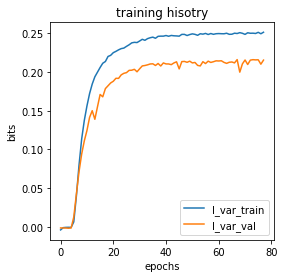

In [13]:
# Show training history
print('On test data:')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')

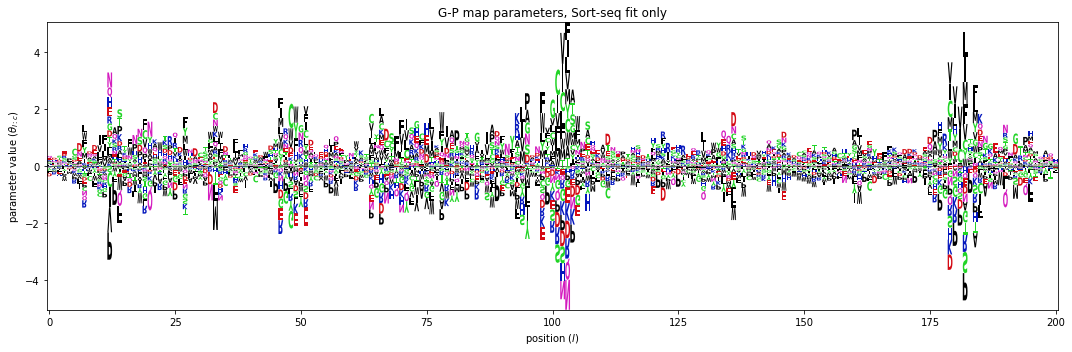

In [14]:
# Get G-P map parameters in matrix form
theta = np.squeeze(gpmap.weights[1].numpy())

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_mpa.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
#measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,1,figsize=[15,5])

# Left panel: draw logo using logomaker
ax = axs
logo = logomaker.Logo(pd.DataFrame(theta,columns=model.alphabet), ax=ax,center_values=True)
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map parameters, Sort-seq fit only')

# Right panel: draw measurement process as heatmap
# ax = axs[1]
# im = ax.imshow(measurement_process,
#                cmap='Greens',
#                extent=phi_lim+y_lim,
#                vmin=0,
#                origin='lower',
#                interpolation='nearest',
#                aspect="auto")
# ax.set_yticks(y_all)
# ax.set_ylabel('bin number (y)')
# ax.set_xlabel('latent phenotype ($\phi$)')
# ax.set_title('measurement process')
# cb = plt.colorbar(im)
# cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout()
fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only.png',dpi=300,bbox_inches='tight')
plt.show()

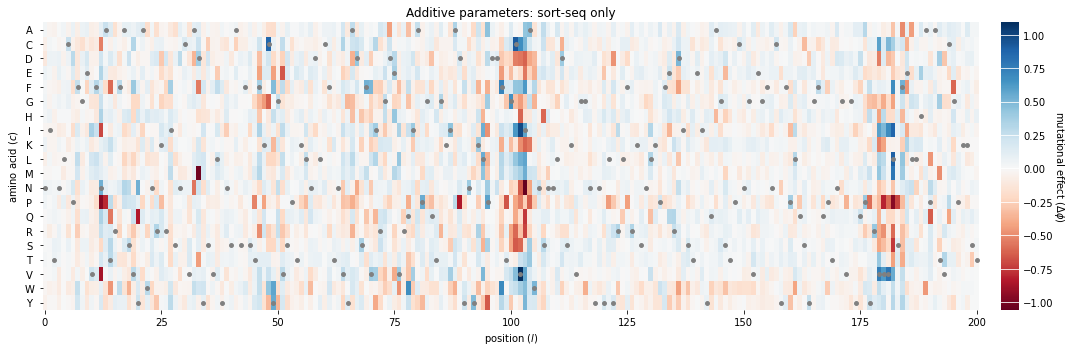

In [24]:
# Create figure
fig, ax = plt.subplots(1,1, figsize=(15,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=logo.df.values,
                                alphabet=alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':15},
                                cmap='RdBu',
                                cbar=True,
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'Additive parameters: sort-seq only')

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Adjust figure and show
fig.tight_layout(w_pad=5)
fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only_heatmap.png',dpi=300,bbox_inches='tight')

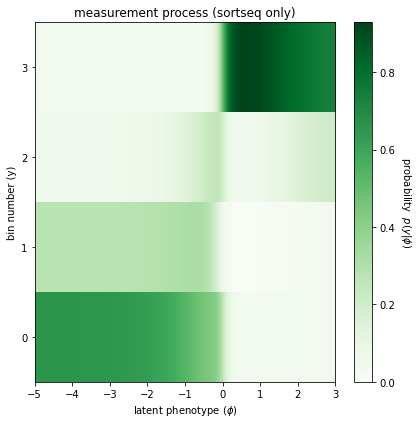

In [16]:
# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_mpa.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)


# Create figure with two panels
fig, ax = plt.subplots(1,1,figsize=[6,6])

# Right panel: draw measurement process as heatmap
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process (sortseq only)')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
fig.tight_layout()
fig.savefig('ace2rbd_mpa_measurment_prcoess_sortseq_only.png',dpi=300,bbox_inches='tight')


In [30]:
np.save('sortseq_gpmap_discrete_agnostic',logo.df.values.ravel())
#np.save('sortseq_gpmap_discrete_agnostic',theta.ravel())